# Toxic Comments Detection Project

# Advanced Machine Learning

### Objective - To classify each comment text to either of the following 6 comment types
#### One comment  can belong to multiple of these types

- Toxic
- Severe_toxic
- Obscene
- Threat
- Insult
- Indetity_Hate

###  Approach - Use a LSTM based Neural Network to predict probabilities for a comment belongin to each of the 6 classification types

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle


### Read Data

In [2]:
dataPath = "./data/"

train = pd.read_csv(dataPath + 'train.csv',index_col=0)
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


**Classes in the Dataset**

In [3]:
types = list(train)[1:]
print(types)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


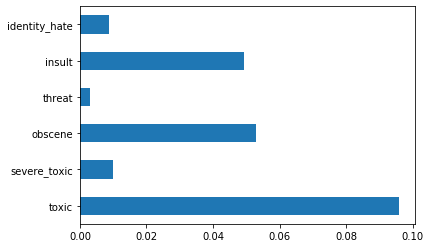

In [4]:
train[types].mean().plot(kind='barh')

**Number of clean comments in the dataset**

In [5]:
nb_clean = (train[types].sum(axis=1)==0).sum()
print('clean:',nb_clean,'(',round(100*nb_clean/len(train),2),'% )')

clean: 143346 ( 89.83 % )


**Some comments in the test set were labelled after the kaggle competition ended. Therefore moving those labelled comments from the test set to the train set**

In [6]:
test = pd.read_csv(dataPath+'test.csv',index_col=0)
test_labels = pd.read_csv(dataPath+'test_labels.csv',index_col=0)
print(test_labels.head())
labelled_test = test.join(test_labels)
disclosed = labelled_test.toxic>-1
print(disclosed .mean(),'% of test is labelled')
train = train.append(labelled_test[disclosed])
test = labelled_test[~disclosed][['comment_text']]
print(train.shape,test.shape)
train.to_csv(dataPath+'tc_train.csv')
test.to_csv(dataPath+'tc_test.csv')

                  toxic  severe_toxic  obscene  threat  insult  identity_hate
id                                                                           
00001cee341fdb12     -1            -1       -1      -1      -1             -1
0000247867823ef7     -1            -1       -1      -1      -1             -1
00013b17ad220c46     -1            -1       -1      -1      -1             -1
00017563c3f7919a     -1            -1       -1      -1      -1             -1
00017695ad8997eb     -1            -1       -1      -1      -1             -1
0.41770912224804785 % of test is labelled
(223549, 7) (89186, 1)


**New train and test shape**

In [7]:
train.head()
train.shape

(223549, 7)

In [8]:
test.head()
test.shape

(89186, 1)

### Create embedding layer using fastext embeddings

In [9]:
# Create embedding index from file in .txt format. First line contains 
# dictionary size and embedding dim. Fields are space separated
def get_embeddings(file_name):
    embeddings_index = {}
    with open(file_name, encoding="utf8") as f:
        for line in f:
            # remove white spaces at the end and split
            values = line.rstrip().split(' ')
            if len(values) > 2:
                embeddings_index[values[0]] = np.asarray(values[1:], dtype="float32")
    return embeddings_index

In [10]:
embeddings_path = './Embeddings1/crawl-300d-2M.vec/'
embeddings_index = get_embeddings(embeddings_path+'crawl-300d-2M.vec')

In [11]:
print(list(embeddings_index.keys())[:25])
ke,va = list(embeddings_index.items())[0]
print('\nFirst key: ',ke,'\n\nVector length: ',len(va),'\n\nVector for first key: ',va)

[',', 'the', '.', 'and', 'to', 'of', 'a', 'in', 'is', 'for', 'that', 'I', 'it', 'on', 'with', ')', ':', '"', '(', 'The', 'you', 'was', 'are', 'or', 'this']

First key:  , 

Vector length:  300 

Vector for first key:  [-2.820e-02 -5.570e-02 -4.510e-02 -4.340e-02  7.120e-02 -8.550e-02
 -1.085e-01 -5.610e-02 -4.523e-01 -2.020e-02  9.750e-02  1.047e-01
  1.962e-01 -6.930e-02  2.130e-02 -2.350e-02  1.336e-01 -4.200e-02
 -5.640e-02 -7.980e-02  4.240e-02 -4.090e-02 -5.360e-02 -2.520e-02
  1.350e-02  6.400e-03  1.235e-01  4.610e-02  1.200e-02 -3.720e-02
  6.500e-02  4.100e-03 -1.074e-01 -2.630e-02  1.133e-01 -2.900e-03
  6.710e-02  1.065e-01  2.340e-02 -1.600e-02  7.000e-03  4.355e-01
 -7.520e-02 -4.328e-01  4.570e-02  6.040e-02 -7.400e-02 -5.500e-03
 -8.900e-03 -2.926e-01 -5.450e-02 -1.519e-01  9.900e-02 -1.930e-02
 -5.000e-03  5.110e-02  4.040e-02  1.023e-01 -1.280e-02  4.880e-02
 -1.567e-01 -7.590e-02 -1.900e-02  1.442e-01  4.700e-03 -1.860e-02
  1.400e-02 -3.850e-02 -8.530e-02  1.572e-01 

**Remove all newline, carriage return, digits and punctuations except apostrophe from the text. Also remove an y consecutivey white spaces and replace it with single white space**

In [157]:
import string
trans_table = str.maketrans({key: ' ' for key in string.digits + '\r\n' +
                             string.punctuation.replace("\'",'')})
def preprocess(text):
    return ' '.join(text.lower().translate(trans_table).split())

### CountVectorizer

Converts text to token counts.<br>
- Fit function learns all the unique words from teh text array and assigns a unique index to each word.<br>
- Then transform function can be used to count words in each new string and update the count of the index of that word<br>
- Q - what if the word is not there in new text?<br>
- A - then that word is not considered in the count<br>
Therefore the count vectorizer should be fit to the whole data set including train and test

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

UNKNOWN_PROXY = 'unknown'
MIN_WORD_OCCURRENCE = 5

train['comment_text'] = train.comment_text.apply(preprocess)
print("Creating the vocabulary of words occurred more than", MIN_WORD_OCCURRENCE)

vectorizer = CountVectorizer(lowercase=False, token_pattern="\S+", 
                             min_df=MIN_WORD_OCCURRENCE)
vectorizer.fit(train.comment_text)

top_words = set(vectorizer.vocabulary_.keys())
top_words.add(UNKNOWN_PROXY)
print(len(top_words),'top words')

Creating the vocabulary of words occurred more than 5
45259 top words


In [14]:
print('First 10 out of "top_words": \n',list(top_words)[:10])
print('\nIs "unknown" in top_words? \n','unknown' in top_words)

First 10 out of "top_words": 
 ['overpopulation', 'disscusion', 'deputies', 'endorse', 'mistress', 'filmmaking', 'ac', 'serpent', 'ruth', 'illness']

Is "unknown" in top_words? 
 True


Mark the words which are not in vocabulary and also not in the embeddings downloaded from FASTTEXT and replace them with text `'unknown'`

In [15]:
def filter_unknown(text, vocabulary, proxy):
    return ' '. \
join([w if w in vocabulary else proxy for w in text.split(' ')])

In [16]:
train['comment_text']  = train.comment_text.apply(filter_unknown,
                args=(set(embeddings_index.keys() & top_words), \
                      UNKNOWN_PROXY))

### Tokenizer

In [17]:
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding

Using TensorFlow backend.


In [18]:
tokenizer = Tokenizer(filters="")
tokenizer.fit_on_texts(train.comment_text)
print(tokenizer)

In [19]:
word_index = tokenizer.word_index
print(len(word_index))
list(word_index.items())[:16]

40185


[('unknown', 1),
 ('the', 2),
 ('to', 3),
 ('of', 4),
 ('and', 5),
 ('a', 6),
 ('you', 7),
 ('i', 8),
 ('is', 9),
 ('that', 10),
 ('in', 11),
 ('it', 12),
 ('for', 13),
 ('this', 14),
 ('not', 15),
 ('on', 16)]

In [20]:
MAX_SEQUENCE_LENGTH = 50
seq = tokenizer.texts_to_sequences(train.comment_text)
data = pad_sequences(seq,maxlen=MAX_SEQUENCE_LENGTH,padding='post',
                     truncating='post')
with open(dataPath + 'toxic_comments.pkl','wb') as f: pickle.dump(data, f, -1)

print('\nFirst 2 sequences in `seq`: ',seq[:2])
print('\nShape of `data`: ',data.shape)
print('\nFirst prepared text in `data`:',data[0])


First 2 sequences in `seq`:  [[668, 77, 2, 133, 130, 176, 31, 658, 4322, 10972, 1109, 85, 347, 1, 52, 1, 12090, 1, 51, 6172, 16, 60, 2522, 147, 8, 2744, 34, 116, 1179, 15205, 2412, 1, 5, 48, 61, 245, 2, 357, 32, 2, 42, 28, 142, 1, 3422, 89, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 53, 2714, 14, 463, 3572, 1, 4414, 2647, 22, 1, 93, 1, 1, 1, 42, 1, 1, 1, 1, 1, 1, 1, 1, 953, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 195, 1]]

Shape of `data`:  (223549, 50)

First prepared text in `data`: [  668    77     2   133   130   176    31   658  4322 10972  1109    85
   347     1    52     1 12090     1    51  6172    16    60  2522   147
     8  2744    34   116  1179 15205  2412     1     5    48    61   245
     2   357    32     2    42    28   142     1  3422    89     1     1
     1     1]


In [21]:
embeddings_dim = len(next(iter(embeddings_index.values())))
embeddings_dim

300

In [22]:
# Create embedding matrix
def get_embedding_matrix(word_index,embeddings_index):
    nb_words = len(word_index) + 1 # +1 since min(word_index.values())=1
    embedding_matrix = np.zeros((nb_words,embeddings_dim))
    unknown = 0
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is None: unknown += 1
        else: embedding_matrix[i] = embedding_vector
    return embedding_matrix, unknown

In [23]:
# Create embedding_layer and save it.
def make_save_emb_layer(word_index,embeddings_index,layer_file_name):
    embedding_matrix,unknown = get_embedding_matrix(word_index,embeddings_index)
    embedding_layer = Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],
                                weights=[embedding_matrix],trainable=False)
    with open(layer_file_name,'wb') as f: 
        pickle.dump(embedding_layer, f, -1)
    return unknown

EMBEDDING_LAYER_FILE = dataPath + 'TOXIC_COMMENTS_EMB_LAYER.pkl'
print(make_save_emb_layer(word_index,embeddings_index,EMBEDDING_LAYER_FILE),
      'unknown words')

W0830 13:39:29.355118  6324 deprecation_wrapper.py:119] From c:\programdata\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



0 unknown words


In [125]:
from keras.layers import Dense,Embedding,Input,Dropout,Conv1D
from keras.layers import SpatialDropout1D, Flatten,LSTM,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import roc_auc_score
from keras.utils import plot_model



def get_model():
    input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
    x = embedding_layer(input_layer)
    x = SpatialDropout1D(0.5)(x)
    x = LSTM(20, return_sequences=True)(x)
    x = Conv1D(20, kernel_size=2, padding="valid")(x)
    y = GlobalMaxPooling1D()(x)
    t = GlobalAveragePooling1D()(x)
    x = concatenate([y,t],name='merge')
    x = BatchNormalization()(x)
    x = Dropout(.2)(x)
    output_layer = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.001))
    return model


In [25]:
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
000103f0d9cfb60f,unknown unknown he matches this background col...,0,0,0,0,0,0
000113f07ec002fd,hey man unknown unknown really not trying to e...,0,0,0,0,0,0
0001b41b1c6bb37e,unknown unknown more i can't make any real sug...,0,0,0,0,0,0
0001d958c54c6e35,you unknown sir unknown are my hero unknown an...,0,0,0,0,0,0


In [26]:
import pickle
from sklearn.model_selection import train_test_split

# convert each vector of labels to the string by concatenating
labels = train[types].astype(str).apply(lambda x: ''.join(x),axis=1)
print('Labels: \n',labels.head())
# aggregate rare combinations if any
count = labels.value_counts()
rare = count.index[count<=2]
labels[np.isin(labels.values,rare)] = 'rare'
print('\nCounts of labels: \n',labels.value_counts())
train_index, val_index = train_test_split(train.index, test_size=0.2, 
                                      stratify = labels, random_state=0)
# save train and validation indices for further calculations
fname = dataPath + 'train_val_split.pkl'
with open(fname, 'wb') as f: pickle.dump([train_index, val_index], f, -1),

Labels: 
 id
0000997932d777bf    000000
000103f0d9cfb60f    000000
000113f07ec002fd    000000
0001b41b1c6bb37e    000000
0001d958c54c6e35    000000
dtype: object

Counts of labels: 
 000000    201081
100000      7376
101010      5732
101000      2612
100010      1754
111010      1165
101011       979
111011       381
001000       366
000010       365
100011       215
100001       203
101110       196
001010       196
111000       186
100100       163
111110        88
101111        81
000001        68
101001        55
111111        45
110000        41
000011        32
000100        27
100110        25
001011        19
101100        17
110010        14
100101        11
110100        11
111100         8
110011         7
111001         7
rare           5
110101         5
000110         4
001001         3
100111         3
110001         3
dtype: int64


In [27]:
with open(EMBEDDING_LAYER_FILE, 'rb') as f: embedding_layer = pickle.load(f)

In [126]:
best_model_path = 'best_model.h5'
BATCH_SIZE = 512

early_stopping = EarlyStopping(patience=2)
model_checkpoint = ModelCheckpoint(best_model_path,
                                   save_best_only=True, save_weights_only=True)
model = get_model()
print(model.summary())
#plot_model(model, to_file='toxic_comments.png',show_shapes=True,show_layer_names=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      12055800    input_10[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_10 (SpatialDr (None, 50, 300)      0           embedding_1[9][0]                
__________________________________________________________________________________________________
lstm_10 (LSTM)                  (None, 50, 20)       25680       spatial_dropout1d_10[0][0]       
__________________________________________________________________________________________________
conv1d_10 

In [29]:
with open(dataPath + 'toxic_comments.pkl', 'rb') as f: data = pickle.load(f) 
with open(dataPath + 'train_val_split.pkl', 'rb') as f: data_idx = pickle.load(f) 

In [30]:
data

array([[ 668,   77,    2, ...,    1,    1,    1],
       [   1,    1,   53, ...,    0,    0,    0],
       [ 437,  415,    1, ...,    0,    0,    0],
       ...,
       [   1,    1, 2026, ...,    0,    0,    0],
       [6555, 6886,    9, ...,    0,    0,    0],
       [   1,    1,    1, ...,    1,    1,   12]])

In [31]:
data.shape

(223549, 50)

In [32]:
len(data_idx[0]),len(data_idx[1])

(178839, 44710)

In [33]:
np.where(train.index.isin(data_idx[0])[0])

(array([0], dtype=int64),)

In [34]:
data[0]

array([  668,    77,     2,   133,   130,   176,    31,   658,  4322,
       10972,  1109,    85,   347,     1,    52,     1, 12090,     1,
          51,  6172,    16,    60,  2522,   147,     8,  2744,    34,
         116,  1179, 15205,  2412,     1,     5,    48,    61,   245,
           2,   357,    32,     2,    42,    28,   142,     1,  3422,
          89,     1,     1,     1,     1])

In [35]:
train.index

Index(['0000997932d777bf', '000103f0d9cfb60f', '000113f07ec002fd',
       '0001b41b1c6bb37e', '0001d958c54c6e35', '00025465d4725e87',
       '0002bcb3da6cb337', '00031b1e95af7921', '00037261f536c51d',
       '00040093b2687caa',
       ...
       'fff69311f306df44', 'fff7159b3ee95618', 'fff718ffe5f05559',
       'fff83b80284d8440', 'fff8f521a7dbcd47', 'fff8f64043129fa2',
       'fff9d70fe0722906', 'fffa8a11c4378854', 'fffac2a094c8e0e2',
       'fffb5451268fb5ba'],
      dtype='object', name='id', length=223549)

In [36]:
X_train = data[train.index.isin(data_idx[0].values)]

In [37]:
X_val = data[train.index.isin(data_idx[1].values)]

In [38]:
y_train=train.iloc[train.index.isin(data_idx[0].values),1:].values

In [39]:
y_val=train.iloc[train.index.isin(data_idx[1].values),1:].values

In [106]:
X_train.shape,y_train.shape,X_val.shape,y_val.shape

((178839, 50), (178839, 6), (44710, 50), (44710, 6))

In [127]:
hist = model.fit(X_train, y_train,validation_data=(X_val, y_val),
                 epochs=50, batch_size=BATCH_SIZE, shuffle=True, verbose=2,
                 callbacks=[model_checkpoint, early_stopping])
model.load_weights(best_model_path)

Train on 178839 samples, validate on 44710 samples
Epoch 1/50
 - 30s - loss: 0.3442 - val_loss: 0.0885
Epoch 2/50
 - 28s - loss: 0.0797 - val_loss: 0.0601
Epoch 3/50
 - 28s - loss: 0.0679 - val_loss: 0.0561
Epoch 4/50
 - 28s - loss: 0.0639 - val_loss: 0.0550
Epoch 5/50
 - 28s - loss: 0.0613 - val_loss: 0.0537
Epoch 6/50
 - 28s - loss: 0.0600 - val_loss: 0.0545
Epoch 7/50
 - 27s - loss: 0.0592 - val_loss: 0.0527
Epoch 8/50
 - 28s - loss: 0.0582 - val_loss: 0.0524
Epoch 9/50
 - 28s - loss: 0.0573 - val_loss: 0.0523
Epoch 10/50
 - 28s - loss: 0.0568 - val_loss: 0.0520
Epoch 11/50
 - 28s - loss: 0.0563 - val_loss: 0.0522
Epoch 12/50
 - 27s - loss: 0.0559 - val_loss: 0.0515
Epoch 13/50
 - 28s - loss: 0.0557 - val_loss: 0.0517
Epoch 14/50
 - 27s - loss: 0.0550 - val_loss: 0.0516


In [128]:
test_pred = model.predict(X_val, batch_size=BATCH_SIZE, verbose=0)
print('validation AUC',roc_auc_score(y_val, test_pred))

validation AUC 0.9782969360974284


In [96]:
test_pred

array([[2.8616190e-02, 2.5317073e-04, 3.4365356e-03, 4.2429566e-04,
        6.1927736e-03, 9.4911456e-04],
       [1.3948232e-02, 1.0100007e-04, 1.9225776e-03, 1.5437603e-04,
        2.8411150e-03, 5.2976608e-04],
       [2.3182720e-02, 2.3519993e-04, 3.3714473e-03, 4.6390295e-04,
        6.4124465e-03, 6.0430169e-04],
       ...,
       [6.6319108e-04, 1.8805265e-05, 3.7053227e-04, 1.8507242e-05,
        1.0150671e-04, 7.0631504e-06],
       [3.9142370e-04, 7.6293945e-06, 1.1059642e-04, 4.1723251e-06,
        6.9111586e-05, 1.2457371e-05],
       [7.0174038e-03, 5.0902367e-05, 1.1603534e-03, 1.3923645e-04,
        1.2416543e-03, 1.5310785e-04]], dtype=float32)

**Process Test Data**

In [43]:
UNKNOWN_PROXY = 'unknown'
MIN_WORD_OCCURRENCE = 5

test['comment_text'] = test.comment_text.apply(preprocess)
print("Creating the vocabulary of words occurred more than", MIN_WORD_OCCURRENCE)

vectorizer = CountVectorizer(lowercase=False, token_pattern="\S+", 
                             min_df=MIN_WORD_OCCURRENCE)
vectorizer.fit(test.comment_text)

top_words = set(vectorizer.vocabulary_.keys())
top_words.add(UNKNOWN_PROXY)
print(len(top_words),'top words')

print('First 10 out of "top_words": \n',list(top_words)[:10])
print('\nIs "unknown" in top_words? \n','unknown' in top_words)

test['comment_text']  = test.comment_text.apply(filter_unknown,
                args=(set(embeddings_index.keys() & top_words), \
                      UNKNOWN_PROXY))

MAX_SEQUENCE_LENGTH = 50
seq = tokenizer.texts_to_sequences(test.comment_text)
data = pad_sequences(seq,maxlen=MAX_SEQUENCE_LENGTH,padding='post',
                     truncating='post')
#with open(dataPath + 'toxic_comments.pkl','wb') as f: pickle.dump(data, f, -1)

print('\nFirst 2 sequences in `seq`: ',seq[:2])
print('\nShape of `data`: ',data.shape)
print('\nFirst prepared text in `data`:',data[0])

Creating the vocabulary of words occurred more than 5
25113 top words
First 10 out of "top_words": 
 ['overpopulation', 'endorse', 'mistress', 'ac', 'ruth', 'illness', 'point', 'categorize', 'corpus', 'implants']

Is "unknown" in top_words? 
 True

First 2 sequences in `seq`:  [[2223, 470, 5992, 678, 9, 59, 18143, 83, 853, 355, 17, 3324, 73, 22, 7, 5, 5919, 7, 1486, 1, 1, 1, 8, 58, 470, 5067, 1698, 1, 603, 5843, 5, 94, 7, 3, 4368, 31, 398, 7, 748, 33797, 38, 1, 5992, 678, 9, 36, 3904, 11, 1546, 639, 415, 1, 488, 19416, 10, 312, 16, 154, 1, 5, 22398, 9, 241, 23218, 50, 15133, 53, 25, 6, 2054, 157, 1, 1, 2602, 603, 2540, 94, 218, 144, 481, 84, 1, 1], [1, 1, 1, 32, 1108, 1, 1, 1, 1, 1, 1, 2, 330, 9, 649, 18, 12, 9, 1, 2606, 1]]

Shape of `data`:  (89186, 50)

First prepared text in `data`: [ 2223   470  5992   678     9    59 18143    83   853   355    17  3324
    73    22     7     5  5919     7  1486     1     1     1     8    58
   470  5067  1698     1   603  5843     5    94     7  

In [84]:
data.shape

(89186, 50)

In [129]:
test_c_pred = model.predict(data, batch_size=BATCH_SIZE, verbose=0)

In [130]:
test_c_pred

array([[9.9516308e-01, 5.6663412e-01, 9.8607445e-01, 1.5909609e-01,
        9.4867778e-01, 2.8173754e-01],
       [1.1588931e-03, 6.8008900e-05, 3.9207935e-04, 6.3210726e-05,
        3.4731627e-04, 8.1002712e-05],
       [2.5899112e-03, 1.9606948e-04, 1.1016130e-03, 8.1419945e-05,
        7.6174736e-04, 2.4750829e-04],
       ...,
       [2.6371181e-03, 1.5234947e-04, 8.4653497e-04, 1.2481213e-04,
        6.4206123e-04, 2.5492907e-04],
       [2.7304292e-03, 1.5819073e-04, 8.5338950e-04, 1.8885732e-04,
        8.8396668e-04, 5.0842762e-04],
       [8.4190166e-01, 1.3477027e-02, 5.7922614e-01, 2.1764338e-03,
        4.4918689e-01, 5.9066713e-03]], dtype=float32)

In [131]:
result = pd.DataFrame(test_c_pred)

In [132]:
result.columns = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [133]:
result['id']=test.index

In [134]:
result.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,id
0,0.995163,0.566634,0.986074,0.159096,0.948678,0.281738,00001cee341fdb12
1,0.001159,0.000068,0.000392,0.000063,0.000347,0.000081,0000247867823ef7
2,0.002590,0.000196,0.001102,0.000081,0.000762,0.000248,00013b17ad220c46
3,0.000657,0.000025,0.000501,0.000046,0.000443,0.000111,00017563c3f7919a
4,0.004571,0.000144,0.000825,0.000080,0.000724,0.000100,00017695ad8997eb


In [135]:
cols = result.columns.tolist()
cols = cols[-1:] + cols[:-1]
result = result[cols]
result.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.995163,0.566634,0.986074,0.159096,0.948678,0.281738
1,0000247867823ef7,0.001159,0.000068,0.000392,0.000063,0.000347,0.000081
2,00013b17ad220c46,0.002590,0.000196,0.001102,0.000081,0.000762,0.000248
3,00017563c3f7919a,0.000657,0.000025,0.000501,0.000046,0.000443,0.000111
4,00017695ad8997eb,0.004571,0.000144,0.000825,0.000080,0.000724,0.000100


In [136]:
result.to_csv('ToxicSubmission6.csv',index=False)

In [ ]:
Correct!
Well done!

Your AUC = 0.965213. Must be not less than threshold = 0.980000. Score = 94.